# Human hematopoiesis
# Pseudotime--cell cycle phases--transition genes expression

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import anndata
import dynamo as dyn
dyn.get_all_dependencies_version()

2023-12-12 22:53:35.404589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 22:53:36.403674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


package,tqdm,statsmodels,setuptools,scipy,scikit-learn,pandas,numpy,networkx,matplotlib,anndata,igraph,loompy,numdifftools,umap-learn,numba,seaborn,colorcet,pynndescent,pre-commit,get-version,openpyxl,typing-extensions,session-info,dynamo-release
version,4.65.0,0.14.0,68.0.0,1.10.0,1.2.2,1.5.3,1.22.3,2.8.4,3.7.1,0.9.1,0.10.4,3.0.7,0.9.41,0.5.3,0.56.4,0.12.2,3.0.1,0.5.8,3.2.0,3.5.4,3.2.0b1,4.5.0,1.0.0,1.3.3


In [2]:
import scvelo as scv
scv.logging.print_version()

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

Running scvelo 0.2.5 (python 3.10.11) on 2023-12-12 22:53.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


## Load data
[hsc_raw_with_metadata.h5ad](https://www.dropbox.com/scl/fi/v2lybgiunboiublxbb45g/hsc_raw_with_metadata.h5ad?rlkey=n8u5h13jb5jmoa28a2o2y2cl0&st=3bz21yf4&dl=0) can be downloaded from dropbox.

In [3]:
adata = anndata.read("hsc_raw_with_metadata.h5ad")

In [5]:
selected_genes_to_use = adata.uns["genes_to_use"]

## Preprocess the Data

In [6]:
dyn.pp.recipe_monocle(
    adata,
    tkey="time",
    experiment_type="one-shot",
    genes_to_use=selected_genes_to_use,
    n_top_genes=len(selected_genes_to_use),
    maintain_n_top_genes=True,
)

|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
Error: The requests_cache python module is required to use request caching.
See - https://requests-cache.readthedocs.io/en/latest/user_guide.html#installation
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-

## Dimension reduction

In [7]:
dyn.tl.reduceDimension(adata)

|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [UMAP] completed [0.1328s]


## Estimate RNA velocity

### use labeling time to group cells for gene expression smoothing

In [8]:
dyn.tl.moments(adata, group="time")

|-----> calculating first/second moments...
|-----> [moments calculation] completed [15.3642s]


In [9]:
adata.uns["pp"]["has_splicing"] = False

### Kinetic estimation

In [10]:
dyn.tl.dynamics(adata, 
                group="time", 
                one_shot_method="sci_fate", 
                model="deterministic")

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group time), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.
|-----> calculating first/second moments...
|-----> [moments calculation] completed [2.9911s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating alpha: 100%|██████████████████████████████████████| 1739/1739 [00:00<00:00, 58726.06it/s]


|-----> calculating first/second moments...
|-----> [moments calculation] completed [2.6768s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating alpha: 100%|██████████████████████████████████████| 1739/1739 [00:00<00:00, 58601.03it/s]


AnnData object with n_obs × n_vars = 1947 × 21416
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'time_3_alpha', 'time_3_beta', 'time_3_gamma', 'time_3_half_life', 'time_3_alpha_b', 'time_3_alpha_r2', 'time_3_gamma_b', 'time_3_gamma_r2', 'time_3_gamma_logLL', 'time_3_delta_b', 'time_3_delta_r2', 'time_3_bs', 'time_3_bf', 'time_3_uu0', 'time_3_ul0', 'time_3_su0', 'time_3_sl0', 'time_3_U0', 'time_3_S0', 'time_3_total0', 'time_3_beta_k', 'time_3_gamma_k', 'time_5_alpha', 'time_5_beta', 'time_5_gamma', 'time_5_half_life', 'time_5_alpha_b', 'time

In [12]:
adata.obs.time.unique()

array([3, 5])

In [13]:
pca_genes = adata.var.use_for_pca
new_expr = adata[:, pca_genes].layers["M_n"]
time_3_gamma = adata[:, pca_genes].var.time_3_gamma.astype(float)
time_5_gamma = adata[:, pca_genes].var.time_5_gamma.astype(float)

t = adata.obs.time.astype(float)
M_s = adata.layers["M_s"][:, pca_genes]

time_3_cells = adata.obs.time == 3
time_5_cells = adata.obs.time == 5

In [15]:
def alpha_minus_gamma_s(new, gamma, t, M_s):
    # equation: alpha = new / (1 - e^{-rt}) * r
    alpha = new.A.T / (1 - np.exp(-gamma.values[:, None] * t.values[None, :])) * gamma.values[:, None]

    gamma_s = gamma.values[:, None] * M_s.A.T
    alpha_minus_gamma_s = alpha - gamma_s
    return alpha_minus_gamma_s

time_3_velocity_n = alpha_minus_gamma_s(new_expr[time_3_cells, :], time_3_gamma, t[time_3_cells], M_s[time_3_cells, :])
time_5_velocity_n = alpha_minus_gamma_s(new_expr[time_5_cells, :], time_5_gamma, t[time_5_cells], M_s[time_5_cells, :])

velocity_n = adata.layers["velocity_N"].copy()

valid_velocity_n = velocity_n[:, pca_genes].copy()
valid_velocity_n[time_3_cells, :] = time_3_velocity_n.T
valid_velocity_n[time_5_cells, :] = time_5_velocity_n.T
velocity_n[:, pca_genes] = valid_velocity_n.copy()

adata.layers["velocity_alpha_minus_gamma_s"] = velocity_n.copy()

### RNA velocity calculating

In [17]:
dyn.tl.cell_velocities(
    adata,
    enforce=True,
    X=adata.layers["M_t"],
    V=adata.layers["velocity_alpha_minus_gamma_s"],
    method="cosine", #['kmc', 'fp', 'cosine', 'pearson', 'transform']
)

|-----> 178 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via cosine kernel with sqrt transform.] completed [150.4060s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.4490s]


AnnData object with n_obs × n_vars = 1947 × 21416
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'time_3_alpha', 'time_3_beta', 'time_3_gamma', 'time_3_half_life', 'time_3_alpha_b', 'time_3_alpha_r2', 'time_3_gamma_b', 'time_3_gamma_r2', 'time_3_gamma_logLL', 'time_3_delta_b', 'time_3_delta_r2', 'time_3_bs', 'time_3_bf', 'time_3_uu0', 'time_3_ul0', 'time_3_su0', 'time_3_sl0', 'time_3_U0', 'time_3_S0', 'time_3_total0', 'time_3_beta_k', 'time_3_gamma_k', 'time_5_alpha', 'time_5_beta', 'time_5_gamma', 'time_5_half_life', 'time_5_alpha_b', 'time

The transition probabilities are computed using cosine correlation between the potential cell-to-cell transitions and the velocity vector, and are stored in a matrix denoted as velocity graph.

In [19]:
scv.tl.velocity_graph(adata)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/192 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Finally, based on the velocity graph, a velocity pseudotime can be computed. After inferring a distribution over root cells from the graph, it measures the average number of steps it takes to reach a cell after walking along the graph starting from the root cells.

Contrarily to diffusion pseudotime, it implicitly infers the root cells and is based on the directed velocity graph instead of the similarity-based diffusion kernel.

In [20]:
scv.tl.velocity_pseudotime(adata)

computing terminal states
    identified 3 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [22]:
rootcell=adata.obs.query("cell_type=='HSC'")
root_cells=adata.obs['root_cells'][rootcell.index]

endcell=adata.obs.query("cell_type=='Meg' or cell_type=='Ery' or cell_type=='Bas' or cell_type=='Mon' or cell_type=='Neu'")
end_cells=adata.obs['end_points'][endcell.index]

In [39]:
scv.tl.velocity_pseudotime(adata, vkey='velocity', 
                           end_key='root_cells',
                           root_key='end_points',
                           n_dcs=40,
                          )

### plot velocity pseudotime

|-----------> plotting with basis key=X_umap


/home/wj/.local/lib/python3.10/site-packages/dynamo/plot/utils.py:395: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ = copy.copy(matplotlib.cm.get_cmap(cmap))
/home/wj/.local/lib/python3.10/site-packages/dynamo/plot/utils.py:571: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/home/wj/.local/lib/python3.10/site-packages/dynamo/plot/utils.py:575: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


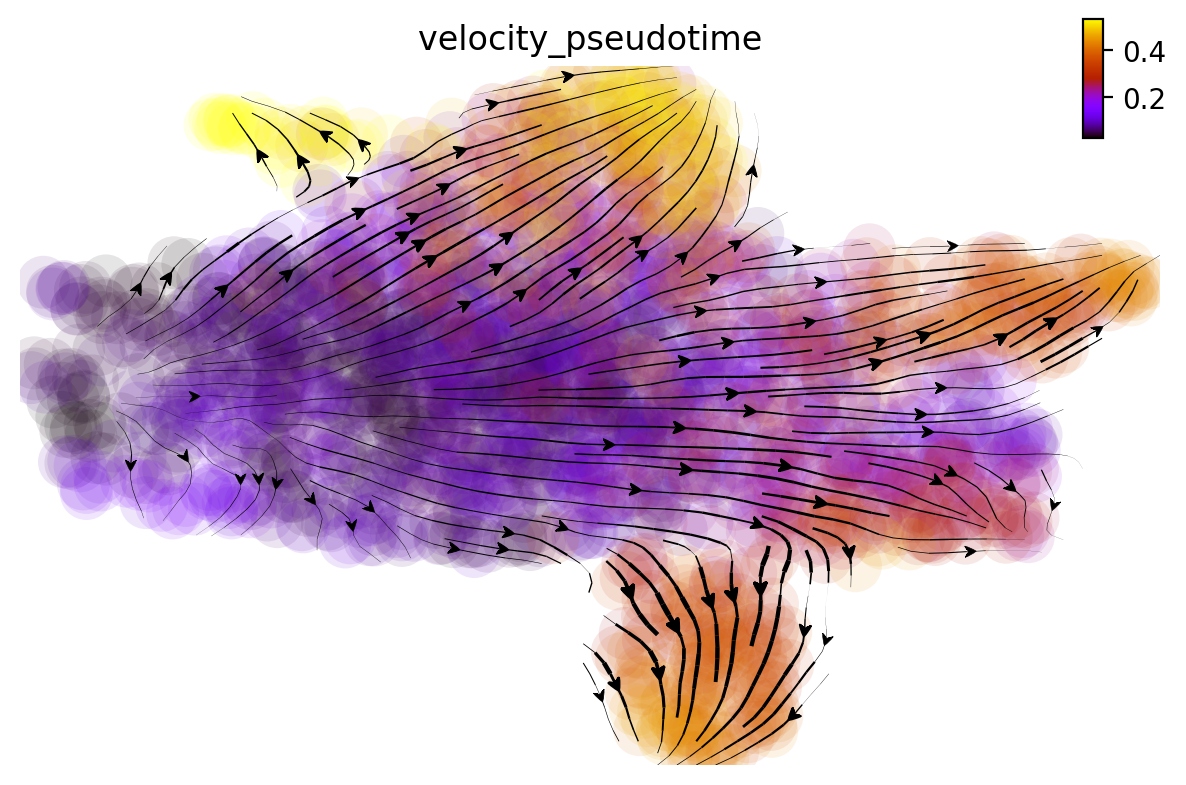

In [40]:
dyn.pl.streamline_plot(
    adata,
    color="velocity_pseudotime",
    basis="umap",
    cmap='gnuplot',
)

## Top-transition genes

In [42]:
velocity_genes = adata.var['velocity_genes'].sort_values(ascending=False).index[:200]
velocity_genes

Index(['CASKIN1', 'CD9', 'RRAS', 'TPM4P2', 'P2RY8', 'LOC107987457', 'TPX2',
       'C18orf54', 'TRIM7-AS1', 'CIB2',
       ...
       'PLK4', 'KYNU', 'RIPK3', 'SOS1', 'LOXL3', 'CD69', 'LMO4', 'LINC01134',
       'LGALS1', 'GUCY1B1'],
      dtype='object', length=200)

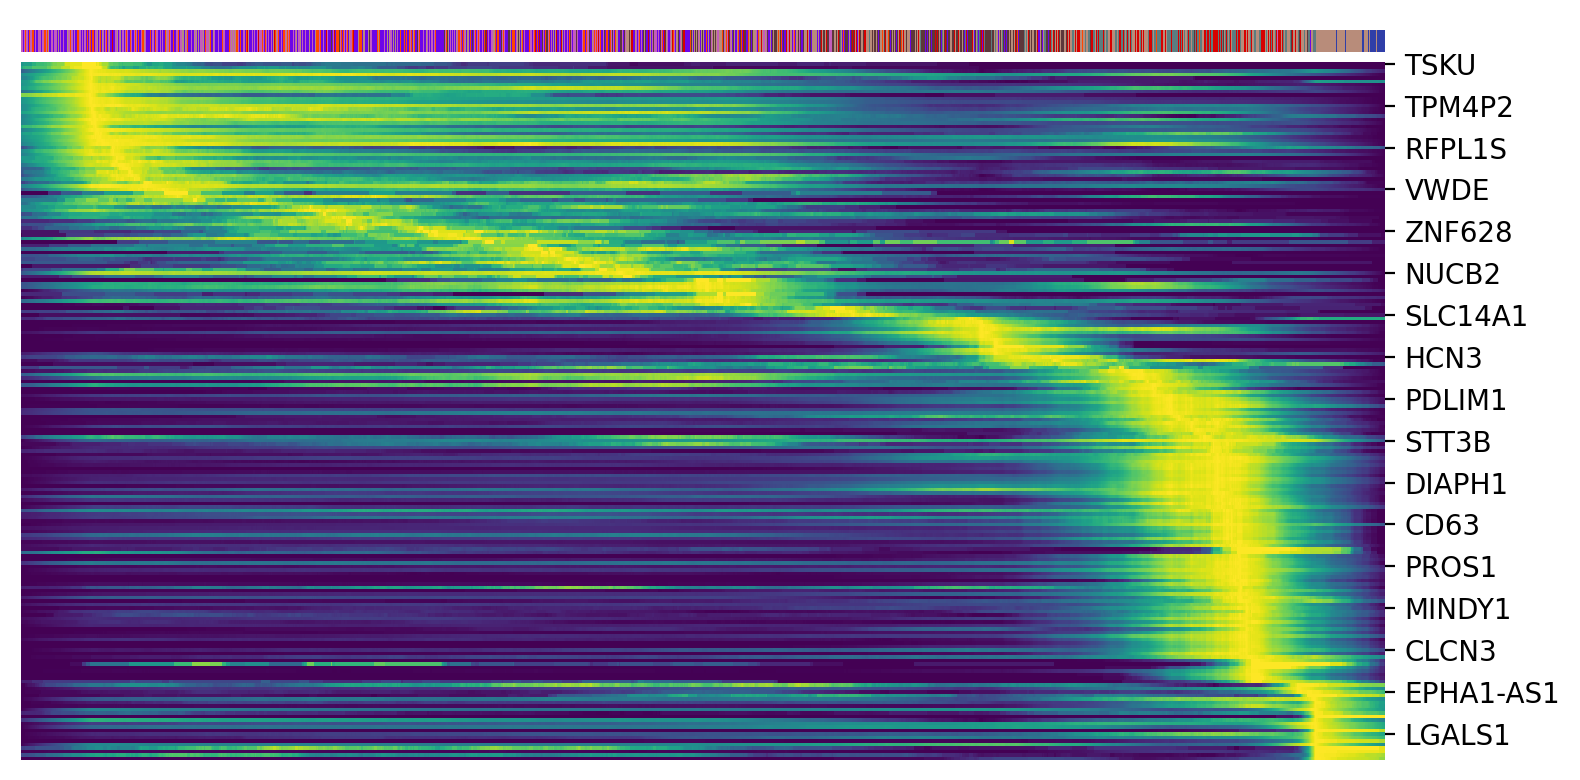

In [43]:
scv.pl.heatmap(adata, 
               var_names=velocity_genes, 
               sortby='velocity_pseudotime', 
               layer='Ms',
               color_map='viridis',
               col_color='cell_type', 
               palette='viridis', 
               n_convolve=200,
               colorbar=None,
               col_cluster=False, 
               row_cluster=False, 
              )

## Velocities in cycling progenitors
The cell cycle detected by RNA velocity, is biologically affirmed by cell cycle scores (standardized scores of mean expression levels of phase marker genes).

In [44]:
scv.tl.score_genes_cell_cycle(adata)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


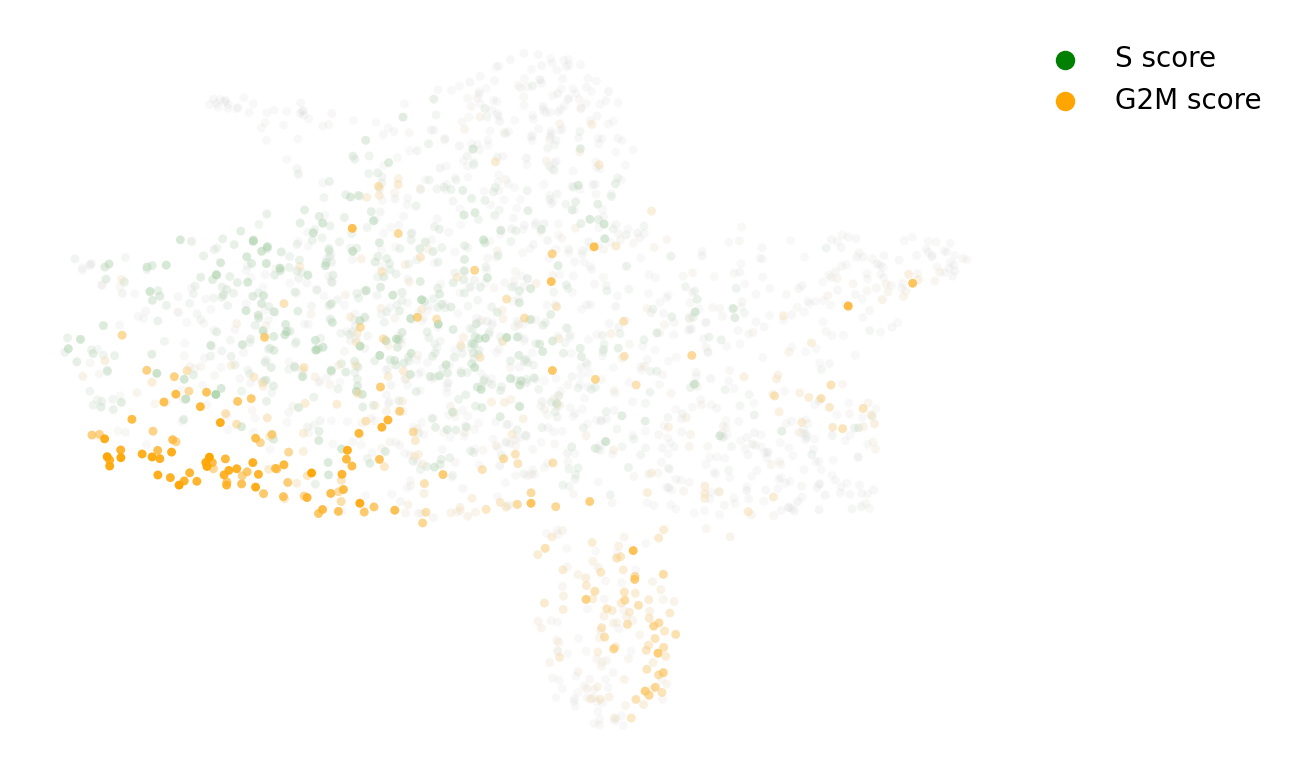

In [45]:
scv.pl.scatter(adata, 
               color_gradients=['S_score', 'G2M_score'], 
               palette=['green', 'orange'], 
               smooth=True, perc=[5, 90])